In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

#**Start With Reading and Exploring our Data**

In [78]:
df = pd.read_csv('/content/housing - housing.csv')

In [79]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


##**Our Goal is to predict median house values our target using the following features so we need to understand each feature first and choose which are the best features that affects our model using correlation feature selection**

In [80]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


##**From this we conclude that :**

longitude & latitude

Represent the geographic location of each district in California.

Range: longitude from -124.35 to -114.31, latitude from 32.54 to 41.95.

Helps models capture regional price trends.

housing_median_age

Median age of houses in each district.

Range: 1–52 years.

The max is capped at 52, so some older houses might be grouped.

total_rooms & total_bedrooms

Total number of rooms/bedrooms in all houses within the block.

Very skewed:

Mean rooms ≈ 2636, but max ≈ 39,320.

Mean bedrooms ≈ 538, but max ≈ 6445.

Suggests outliers → should consider feature scaling or capping.

population

Total population in the block.

Range: 3 – 35,682.

Highly skewed; large variance.

households

Total number of households (family units) in the block.

Range: 1 – 6082.

Median is around 409 households.

median_income

Median income of households in the block (in tens of thousands of USD).

Range: 0.4999 – 15.0001.

Mean ≈ 3.87 → around $38,700/year.

This is one of the most important predictors of house value.

median_house_value (target)

Median house price in the block (USD).

Range: $14,999 – $500,001.

The max value is capped at $500,001, so the dataset has an artificial ceiling effect (important in regression modeling).

Mean ≈ $206,855; median ≈ $179,700

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


##**All the dtypes except the ocean_proximity column which is of type object which we need to make it numerical before using**

#**Preprocessing Phase for our model**

##**Handling nulls**

In [82]:
df.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [83]:
df['total_bedrooms'].skew()

np.float64(3.459546331523342)

###**Cause of high skewness we are going to replace nulls with the median of the column**

In [84]:
df.fillna(df['total_bedrooms'].median(),inplace=True)

In [85]:
df.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


##**Check outliers and replace them with the higher bound if > higher bound and replace them with lower bound if < lowerbound and we will calc them using the IQR of our data**

In [86]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] > upper_bound, upper_bound,
                       np.where(df[col] < lower_bound, lower_bound, df[col]))

print("Outliers handled for numerical columns.")

Outliers handled for numerical columns.


##**Encoding step for the non numerical columns using the Label encoding method**

In [87]:
le = LabelEncoder()
df['ocean_proximity'] = le.fit_transform(df['ocean_proximity'])

##**Checking on duplicates step**

In [88]:
df.duplicated().sum()

np.int64(0)

###**No duplicates need to be handled in our data**

#**Feature construction part**

In [89]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']
df["income_per_household"] = df["median_income"] / df["households"]
df["population_per_room"] = df["population"] / df["total_rooms"]
df["bedrooms_per_household"] = df["total_bedrooms"] / df["households"]

##**Data normlaiztaion and feature scaling to Range between 0 to 1**

In [90]:
standard_features = ["housing_median_age", "total_rooms", "total_bedrooms",
                     "population", "households", "median_income","income_per_household"]

minmax_features = ["longitude", "latitude","population_per_room","bedrooms_per_household"]

scaler_standard = StandardScaler()
df[standard_features] = scaler_standard.fit_transform(df[standard_features])
scaler_minmax = MinMaxScaler()
df[minmax_features] = scaler_minmax.fit_transform(df[minmax_features])

In [91]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_per_household,population_per_room,bedrooms_per_household
0,0.211155,0.567481,0.982143,-1.117285,-1.309916,-1.325821,-1.291972,2.541006,452600.0,3,6.984127,0.146591,2.555556,0.664927,0.002110,0.020469
1,0.212151,0.565356,-0.607019,2.329936,2.128690,1.389936,2.348314,2.541006,358500.0,3,5.215904,0.194090,2.197712,-0.104576,0.002446,0.020129
2,0.210159,0.564293,1.856182,-0.697327,-1.095223,-1.098528,-1.099883,2.085156,352100.0,3,8.288136,0.129516,2.802260,0.355911,0.001941,0.021940
3,0.209163,0.564293,1.856182,-0.835405,-0.936843,-1.017539,-0.941691,1.111288,341300.0,3,5.817352,0.184458,2.547945,0.147540,0.002547,0.021929
4,0.209163,0.564293,1.856182,-0.582857,-0.778463,-1.008395,-0.791033,0.027262,342200.0,3,6.281853,0.172096,2.181467,-0.001782,0.001997,0.022166


##**Features selection using corellation heat map**

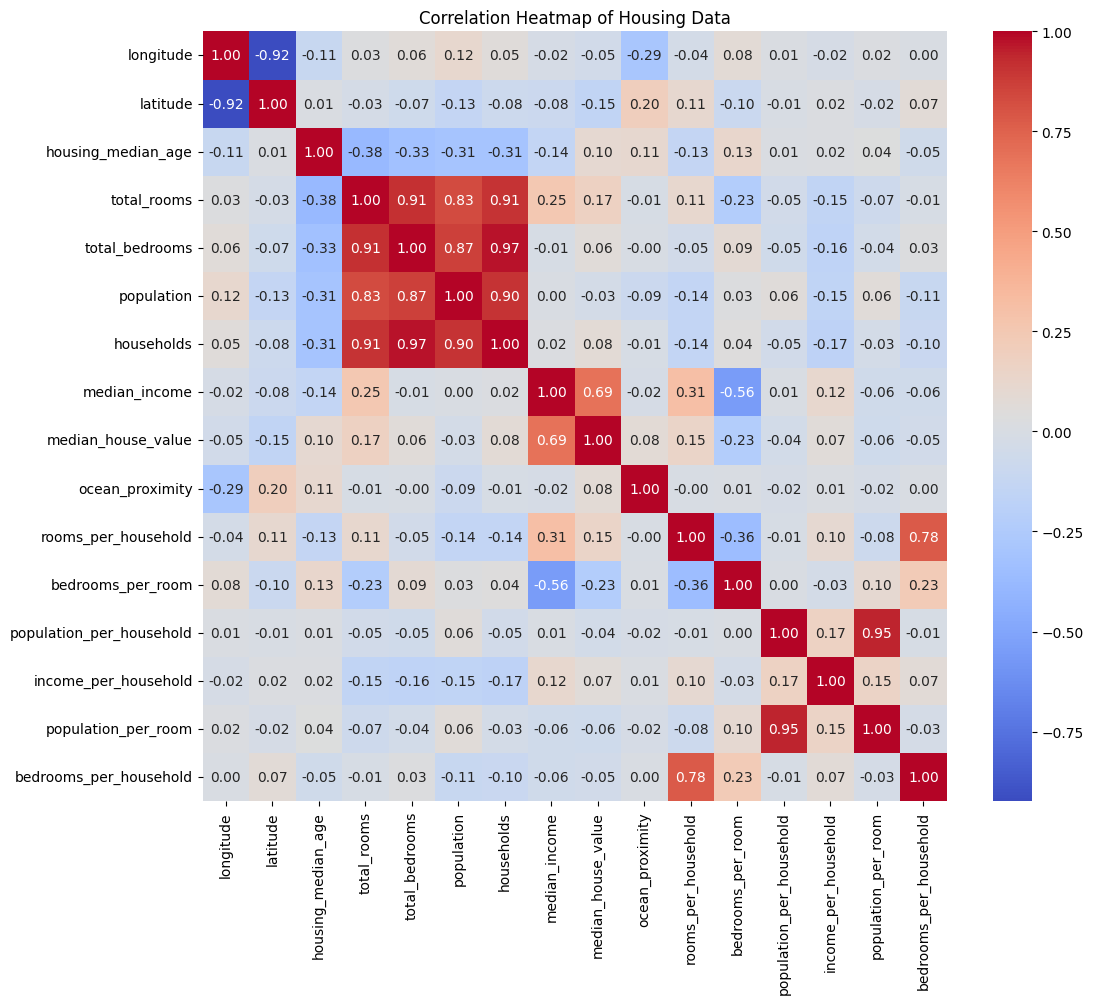

In [92]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Housing Data')
plt.show()

###**Useful features that we could use in our training is bedrooms_per_room , rooms_per_household,median_income,total_rooms,house age median,latitude are the data we could use to predict the median house value as they have good corelation value with our target feature**

##**Construct our x and y for model train**

In [93]:
x = df[['bedrooms_per_room','rooms_per_household','median_income','total_rooms','housing_median_age','latitude','longitude','income_per_household']]
y = df['median_house_value']

##**Train Test Split step**

In [94]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15,random_state=100)

#**Models Training and Eval step**

##**Linear Regression model**

In [95]:
linear = LinearRegression()
linear.fit(x_train,y_train)

LinearRegression()

In [96]:
y_pred = linear.predict(x_test)

In [97]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("MAE:", mae)
print("R2:",r2)

MSE: 4693964088.059892
MAE: 51974.7156960429
R2: 0.6341758224668315


###**By using linear regression model we achived a accuracy of 63% so will the random forest Regressor inc the accuracy a bit or not?**

##**Random forest Regressor model**

###**Run random search to choose the best hyper params for our model**

In [98]:
rf = RandomForestRegressor(random_state=42)

In [99]:
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='r2',
    n_jobs=2,
    verbose=2,
    random_state=42
)

In [100]:
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=2,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42, scoring='r2', verbose=2)

###**After running the random search we are going to print the best params and the best accuracy achived using a certain combination on dataset from diff hyperparameters**

In [101]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}
Best score: 0.7965682351790812


# **From this we conclude that using Random Forest yields much better accuracy for our model because**  
- It captures **non-linear relationships** between features and the target, unlike Linear Regression which assumes linearity.  
- It reduces **overfitting** by averaging results from many decision trees (bagging).  
- It handles **outliers and skewed distributions** more robustly.  
- It automatically captures **feature interactions** without us needing to explicitly create them.  
- It provides **feature importance scores**, helping us understand which features influence housing prices the most.  
- Compared to a simple linear model, Random Forest adapts better to the complexity of housing data (population, income, location, etc.).  

👉 Therefore, Random Forest not only improves accuracy but also makes the model more **generalizable** and reliable for unseen data.
